In [1]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Relay:
    # Класс релейных защит
    def __init__(self, relay_type, Ir=None, Tr=None, Ir2=None, Tr2=None):
        self.Ir = Ir
        self.Tr = Tr
        self.Ir2 = Ir2
        self.Tr2 = Tr2
        # Выбор типа реле
        if relay_type == 'РТ-40':
            self.relay_func = self._RT40
        elif relay_type == 'РТВ-1':
            self.relay_func = self._RT40
        elif relay_type == 'Сириус-2':
            self.relay_func = self._Sirius
        elif relay_type == 'ПКТ-20А':
            data = pd.read_excel('ПКТ-20А.xlsx')
            self.relay_func = interp1d(data['x'], data['y'], bounds_error=False)
    
    def eval(self, I):
        if isinstance(I, int) or isinstance(I, float):
            return self.relay_func(I)
        else:
            return np.array([self.relay_func(i) for i in I])

    def _RT40(self, i):
        #РТВ-1 - реле с замедлением
        if i > self.Ir:
            return self.Tr
            #return 1 / 30 / (i / self.Ir - 1)**3 + self.Tr
        else:
            return 1000

    def _Sirius(self, i):
        if i > self.Ir:
            t1 = (0.14 * self.Tr) / ((i / self.Ir)**0.02 - 1)
        else:
            t1 = np.inf
            
        if i > self.Ir2:
            t2 = self.Tr2
        else:
            t2 = np.inf
        return min([t1, t2])

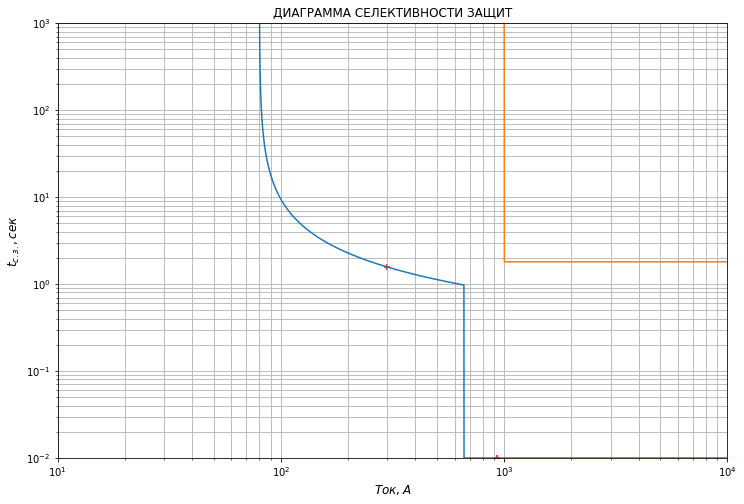

In [9]:
R1 = Relay('Сириус-2', 80, 0.3, 660, 0.01)
R2 = Relay('РТ-40', 1000, 1.8)

Ikz3 = 930
Ikz3_tr = 300

x = np.arange(10, 10000, 0.1)

plt.figure(figsize=(12,8))

plt.plot(x, R1.eval(x))
plt.plot(x, R2.eval(x))

plt.scatter(Ikz3, R1.eval(Ikz3), c='r', marker='+') #Iкз(3)
plt.scatter(Ikz3_tr, R1.eval(Ikz3_tr), c='r', marker='+') #Iкз(3) за трансформатором

plt.xlabel(r'$Ток, А$', fontsize=12)
plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.ylim(0.01, 1000)
plt.xlim(10, 10000)
plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
plt.savefig('E:\Проекты\ЭПВ-2019-06 КТП Бахрушиных\Диаграмма селективности.png', bbox_inches='tight', dpi=300)

In [41]:
R1.eval(Ikz3_tr)

1.5678882256036142

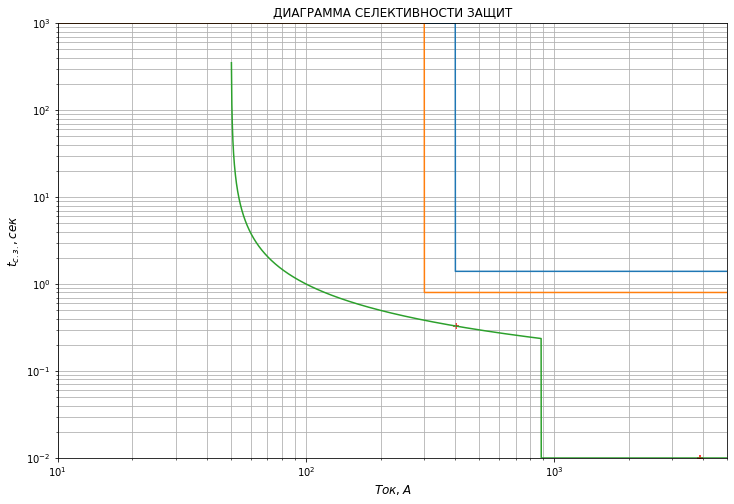

In [13]:
R1 = Relay('РТ-40', 400, 1.4)
R2 = Relay('РТ-40', 300, 0.8)
R3 = Relay('Сириус-2', 50, 0.1, 887.5, 0.01)


Ikz2_k4 = 402
Ikz3_k3 = 3890

x = np.arange(10, 10000, 0.1)

plt.figure(figsize=(12,8))

#plt.plot(x, R1.eval(x)*0.8)
#plt.plot(x, R1.eval(x) * 1.2)
plt.plot(x, R1.eval(x))
plt.plot(x, R2.eval(x))
plt.plot(x, R3.eval(x))

#plt.fill_between(x, y1=R3.eval(x)*0.8, y2=R3.eval(x)*1.2, color='g')

plt.scatter(Ikz2_k4, R3.eval(Ikz2_k4), marker='+',  c='r')
plt.scatter(Ikz3_k3, R3.eval(Ikz3_k3), marker='+', c='r')


plt.xlabel(r'$Ток, А$', fontsize=12)
plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.ylim(0.01,1000)
plt.xlim(10, 5000)
plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
plt.savefig('E:\Проекты\ЭПВ-2019-01 Горшково\Диаграмма селективности.png', bbox_inches='tight', dpi=300)

In [12]:
R3.eval(Ikz2_k4)

0.32887200563296093